In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model
from tensorflow.keras.applications import VGG16

In [3]:
Image_size = 224
Batch_size = 32
Channels=3
Epochs=15

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "combined",
    shuffle=True,
    image_size = (Image_size,Image_size),
    batch_size = Batch_size
)

Found 700 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['cancer', 'non_cancer']

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]


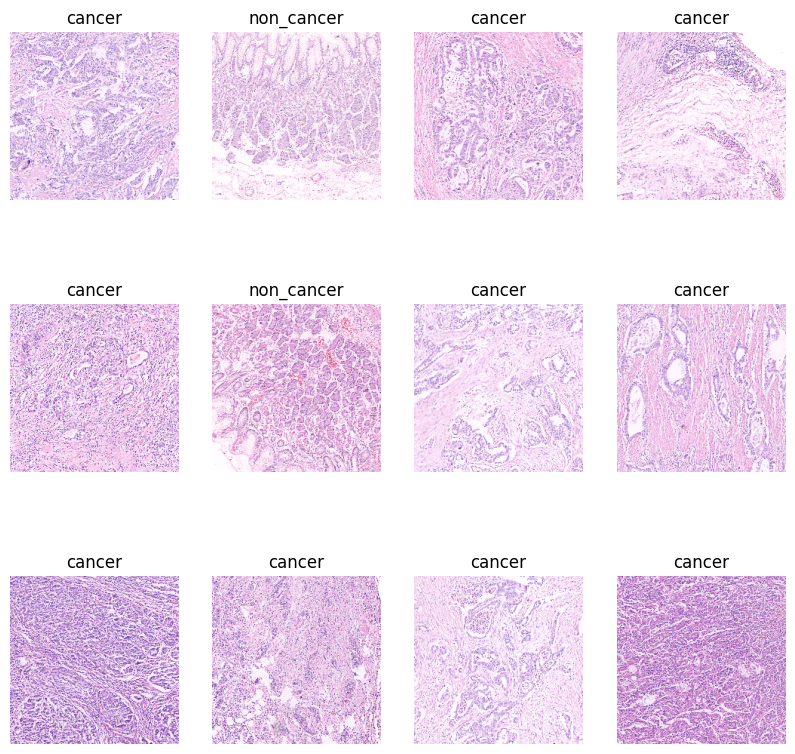

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    dataset_size=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*dataset_size)
    val_size=int(val_split*dataset_size)
    Train_dataset= dataset.take(train_size)
    Val_dataset=dataset.skip(train_size).take(val_size)
    Test_dataset=dataset.skip(train_size).skip(val_size)
    return Train_dataset,Val_dataset,Test_dataset

In [9]:
Train_dataset,Val_dataset,Test_dataset=dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000)

In [10]:
len(Train_dataset)

17

In [11]:
len(Val_dataset)

2

In [12]:
len(Test_dataset)

3

In [13]:
Train_dataset=Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_dataset=Val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_dataset=Test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size,Image_size),
    layers.Rescaling(1.0 / 255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [16]:
# input_shape=(Batch_size,Image_size,Image_size,Channels)
# model= models.Sequential([
#     resize_and_rescale,
#     data_augmentation,

#     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
    
#     layers.Flatten(),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(32,activation='relu'),
#     layers.Dense(3,activation='softmax')
# ])

# model.build(input_shape=input_shape)

In [17]:
#vgg16 code
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [18]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
#vgg16
model= models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(16,activation='relu'),
    layers.Dense(1,activation='sigmoid'),

])
model.build(input_shape=(None,224, 224, 3))

In [20]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )


In [21]:
#vgg16
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [22]:
#vgg16
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,081 (59.20 MB)

 Trainable params: 803,393 (3.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
history = model.fit(
    Train_dataset,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=Val_dataset
)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 255s 10s/step - accuracy: 0.7035 - loss: 1.4283 - val_accuracy: 0.9062 - val_loss: 0.2324
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.8140 - loss: 0.5418 - val_accuracy: 0.8594 - val_loss: 0.5610
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9328 - loss: 0.2716 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9877 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0158
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_los

In [24]:
scores= model.evaluate(Test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.9831 - loss: 0.0310


In [25]:
scores

[0.020061606541275978, 0.9895833134651184]

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training loss and Validation loss Accuracy')

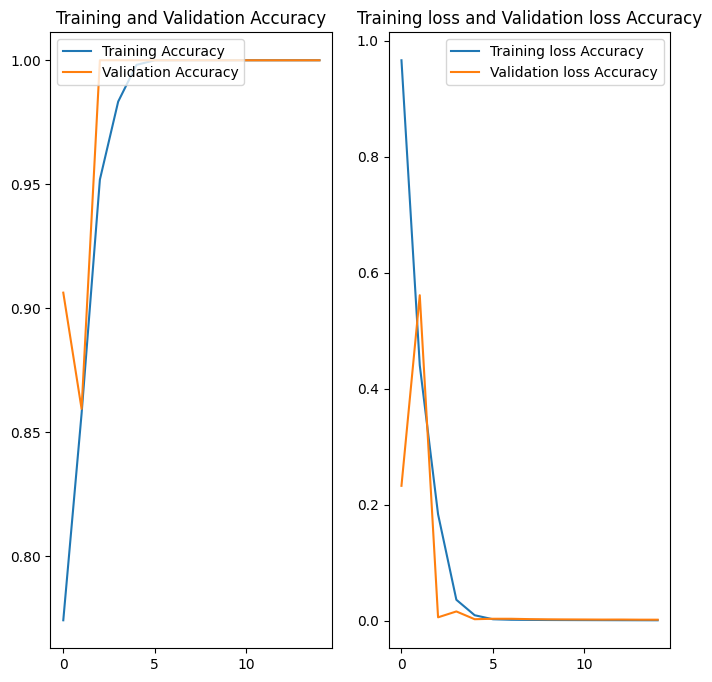

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label='Training loss Accuracy')
plt.plot(range(Epochs),val_loss,label='Validation loss Accuracy')
plt.legend(loc='upper right')
plt.title('Training loss and Validation loss Accuracy')

first image to Predict
actual label: cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[0.99999994]
predicted label  cancer


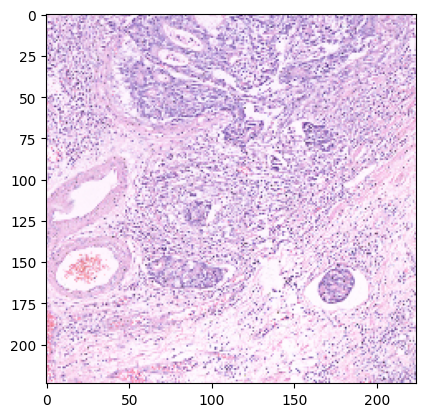

In [40]:
for image_batch,labels_batch in Test_dataset.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print(1-batch_prediction[0])
    print("predicted label ",class_names[np.argmax(batch_prediction[0])])


In [29]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


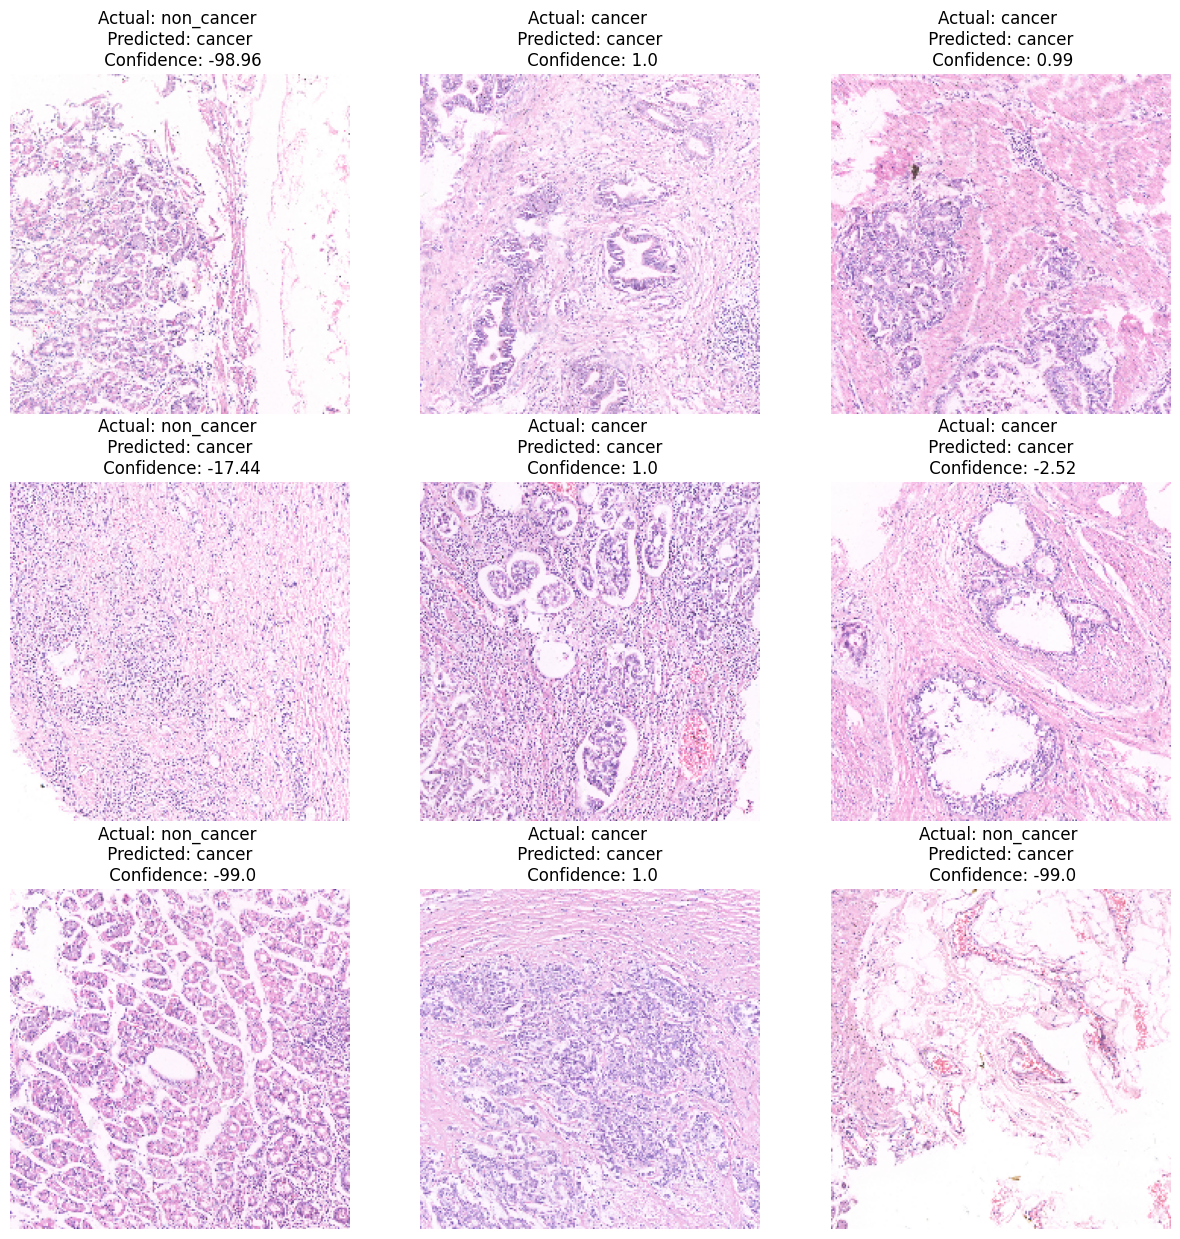

In [41]:
plt.figure(figsize=(15,15))
for images,labels in Test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {1-confidence}")

        plt.axis("off")

In [31]:
import os
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# Directory where you want to save the model
save_directory = r"model"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Assuming you have a trained model named 'model'

# Save model architecture as JSON
model_json = model.to_json()
with open(os.path.join(save_directory, "model.json"), "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights(os.path.join(save_directory, "model_weights.weights.h5"))






In [32]:
def save_history(History):
    acc = pd.Series(History.history['accuracy'], name='accuracy')
    loss = pd.Series(History.history['loss'], name='loss')
    val_acc = pd.Series(History.history['val_accuracy'], name='val_accuracy')
    val_loss = pd.Series(History.history['val_loss'], name='val_loss')
    com = pd.concat([acc, loss, val_acc, val_loss], axis=1)
    # Be sure to update the storage location!!
    com.to_csv('D:\\meracode\\model\\history.csv')


In [33]:
save_history(history)

In [44]:
def plot_history(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(range(Epochs),acc,label='Training Accuracy')
    plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(range(Epochs),loss,label='Training loss Accuracy')
    plt.plot(range(Epochs),val_loss,label='Validation loss Accuracy')
    plt.legend(loc='upper right')
    plt.title('Training loss and Validation loss Accuracy') 

    plt.tight_layout()
    plt.show()

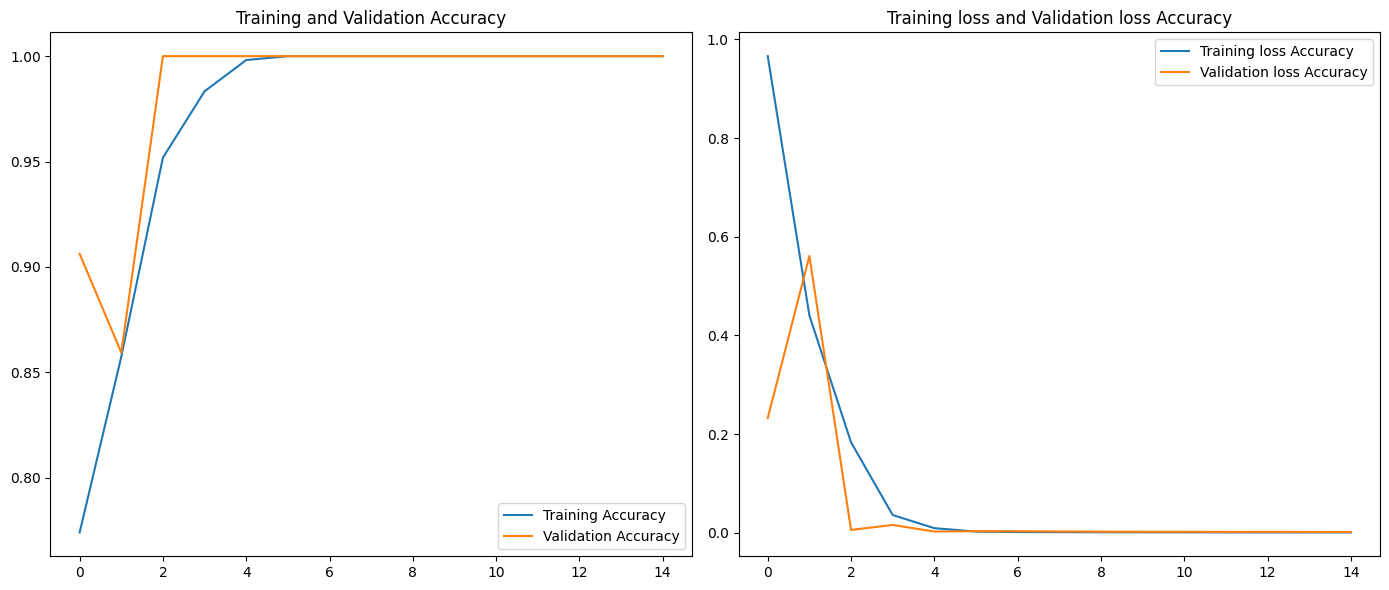

In [45]:
plot_history(history)


In [46]:

def moving_average(data, window_size):
    # Create a kernel for the moving average
    kernel = np.ones(window_size) / window_size
    # Apply the moving average filter
    smoothed_data = np.convolve(data, kernel, mode='same')
    return smoothed_data

def plot_history_smoothed(history, window_size=3):
    Epochs = len(history.history['accuracy'])
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['accuracy'], window_size), label='Training Accuracy', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_accuracy'], window_size), label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['loss'], window_size), label='Training Loss', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_loss'], window_size), label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()


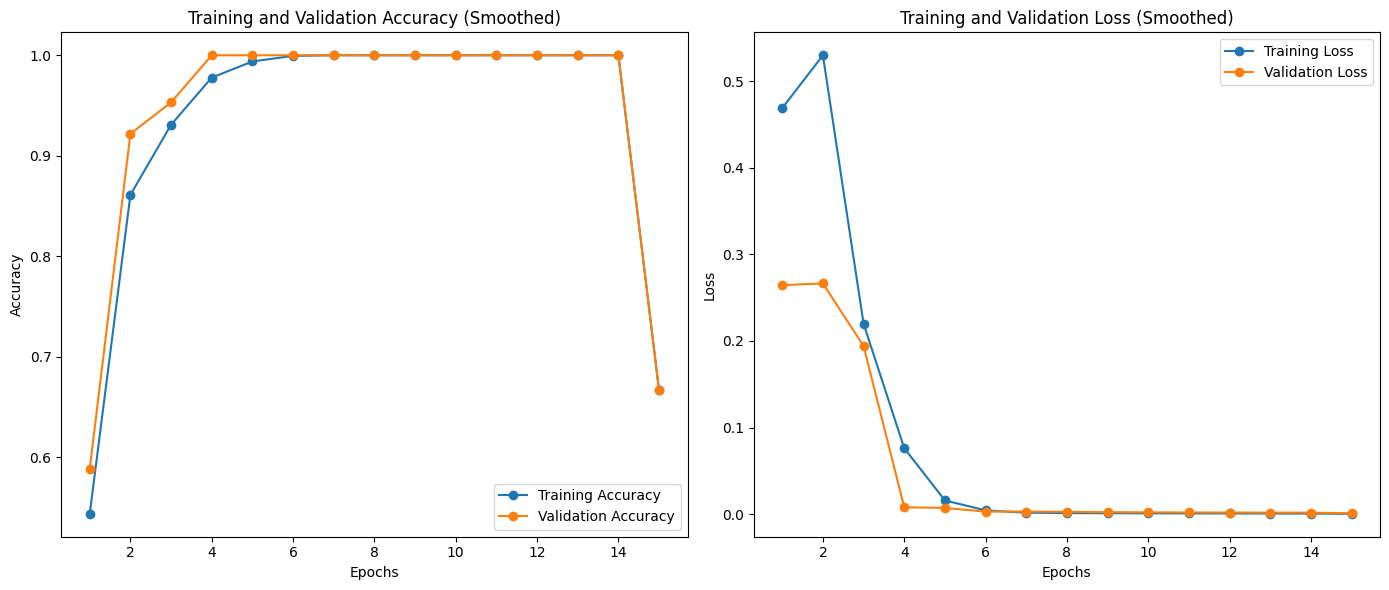

In [47]:
plot_history_smoothed(history, window_size=3)